# Comparing Two Climate Models

In this notebook, I will be comparing two climate reanalysis models:

* NCEP-DOE Reanalysis 2: Surface
* ERA5

I will be looking at the following variables:

* Surface Pressure
* Mean Sea Level Pressure
* Total Column Water

The idea is simple: these two models should have very similar properties. I will be trying to user RBIG in order to assess how similar these models are. I'll be looking at the following IT measures

* Entropy
* Total Correlation
* Mutual Information

If these climate models are that similar, then they should exhibit similar IT measures.

## Data - Climate Models

In [15]:
import os, sys
cwd = os.getcwd()
source_path = f"{cwd}/../../"
sys.path.insert(0, f'{source_path}')

# Import RBIG Helper
from src.models.train_models import run_rbig_models

# ESDC tools
sys.path.insert(0, f'/home/emmanuel/code/py_esdc')
from esdc.preprocessing import normalize_temporal

import cdsapi
from zipfile import ZipFile
import pandas as pd
import xarray as xr
from tqdm import tqdm
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
data_path = f"/home/emmanuel/projects/2020_rbig_rs/data/climate/raw/"
results_path = f"/home/emmanuel/projects/2020_rbig_rs/data/climate/results/"
fig_path = f"/home/emmanuel/projects/2020_rbig_rs/reports/figures/climate/"

#### ERA5

In [17]:
era5_data = xr.open_dataset(f"{data_path}ERA5.nc")
era5_data = era5_data.rename({'msl': 'mslp', 'latitude': 'lat', 'longitude': 'lon'})
# era5_data = era5_data.rename({'latitude': 'lat'})
# era5_data.attrs['model_id'] = 'era5'
# rescale model from 0.25 to 2.5 degrees
era5_data = era5_data.coarsen(lat=10, lon=10, boundary='pad').mean()
era5_data.attrs['model_id'] = 'era5'
era5_data

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 487)
Coordinates:
  * lon      (lon) float32 1.125 3.625 6.125 8.625 ... 353.625 356.125 358.625
  * lat      (lat) float32 88.875 86.375 83.875 81.375 ... -86.125 -88.625 -90.0
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2019-07-01
Data variables:
    mslp     (time, lat, lon) float32 102587.54 102588.4 ... 101630.42 101630.42
    sp       (time, lat, lon) float32 102588.0 102589.81 ... 68592.39 68592.39
Attributes:
    model_id:  era5

#### NCAR-NCEP-DOE-II

In [18]:
ncep_data = xr.open_mfdataset(f"{data_path}*mon.mean.nc")
ncep_data = ncep_data.rename({'pres': 'sp'})
ncep_data.attrs['model_id'] = 'ncar_ncep_doe_2'
ncep_data

<xarray.Dataset>
Dimensions:    (lat: 73, lon: 144, nbnds: 2, time: 489)
Coordinates:
  * lat        (lat) float32 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2019-09-01
Dimensions without coordinates: nbnds
Data variables:
    mslp       (time, lat, lon) float32 dask.array<chunksize=(489, 73, 144), meta=np.ndarray>
    time_bnds  (time, nbnds) datetime64[ns] dask.array<chunksize=(489, 2), meta=np.ndarray>
    pr_wtr     (time, lat, lon) float32 dask.array<chunksize=(489, 73, 144), meta=np.ndarray>
    sp         (time, lat, lon) float32 dask.array<chunksize=(489, 73, 144), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.0
    title:          Monthly NCEP/DOE Reanalysis 2
    history:        created 2002/03 by Hoop (netCDF2.3)
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    s

## Experiment I - Comparing Climate Models

### Mean Sea Level Pressure

In [19]:
# Experiment class
class ClimateEntropy:
    def __init__(self, save_path: None, variable: str='mslp'):
        
        self.variable = variable
        
        self.results_path = save_path
        self.results_df = pd.DataFrame()
    
    def run_experiment(self, climate_model1: pd.DataFrame, climate_model2: pd.DataFrame) -> None:
        """Training loop that goes through each year and calculates the entropy,
        total correlation and mutual information between the two models."""
        time_length = len(climate_model1.groupby('time.year'))
        
        # Normalize BEFORE the individual calculations
        climate_model1[self.variable] = normalize_temporal(climate_model1[self.variable])
        
        model1_id = climate_model1.attrs['model_id']
        model2_id = climate_model2.attrs['model_id']
        climate_model2[self.variable] = normalize_temporal(climate_model2[self.variable])
        
        with tqdm(zip(
            climate_model1.groupby('time.year'), 
            climate_model2.groupby('time.year')
        ), total=time_length) as progress_bar:
            
            for imodel1, imodel2 in progress_bar:
                
                # Update params in progress bar
                
                # Transform to dataframe, remove spatial dimensions
                X1 = self._get_time_features(imodel1[1][self.variable])
                X2 = self._get_time_features(imodel2[1][self.variable])
                
                # Normalize inputs
                min_max_scaler = preprocessing.StandardScaler()
                X1 = min_max_scaler.fit_transform(X1.values)
                X2 = min_max_scaler.fit_transform(X2.values)
                
                dims = X1.shape[1]
                
                # =============================
                # Calculate Mutual Information
                # =============================
                mi_, mi_t_ = run_rbig_models(X1, X2, measure='mi', verbose=None)
                
                
                # Update params in progress bar
                postfix = dict(
                    
                )

                # ========================================
                # Calculate Entropy and Total Correlation
                # ========================================
                
                # Model I
                tc1_, h1_, h_t1_ = run_rbig_models(X1, measure='t', verbose=None)
                
                self._update_results(
                    model=model1_id,
                    year=imodel1[0],
                    h_time=h_t1_,
                    tc=tc1_,
                    h=h1_,
                    mi=mi_,
                    mi_time=mi_t_,
                    dims=dims,
                    
                )
                
                
                # Model II
                tc2_, h2_, h_t2_ = run_rbig_models(X2, measure='t', verbose=None)
                self._update_results(
                    model=model2_id,
                    year=imodel2[0],
                    h_time=h_t2_,
                    tc=tc2_,
                    h=h2_,
                    mi=mi_,
                    mi_time=mi_t_,
                    dims=dims,
                    
                )
                
                # Update params in progress bar
                postfix = dict(
                    year=imodel1[0],
                    mi=f"{mi_:.3f}",
                    h1=f"{h1_:.3f}",
                    tc1=f"{tc1_:.3f}",
                    h2=f"{h2_:.3f}",
                    tc2=f"{tc2_:.3f}",
                )
                

                
                progress_bar.set_postfix(postfix)
            
        
        return None
    
    def _get_time_features(self, data_df: pd.DataFrame)-> pd.DataFrame:
        """This function collapses the spatial dimensions as pivots. This allows
        us to only consider time as the input feature."""
        return data_df.to_dataframe().unstack(level=0).reset_index().drop(columns=['lat', 'lon']).dropna()
    
    def _update_results(self, model, year, tc, h, h_time, mi, mi_time, dims):
        """appends new values to the results dataframe."""
        self.results_df = self.results_df.append({
            'model': model,
            'year': year,
            'tc': tc,
            'h': h,
            'h_time': h_time,
            'mi': mi,
            'mi_time': mi_time,
            'dims': dims,
        }, ignore_index=True
        )
        
        if self.results_path is not None:
            self._save_results()
        return self
    
    def _save_results(self):
        """Saves the dataframe to the assigned results path."""
        self.results_df.to_csv(f"{self.results_path}{self.variable}.csv")
        return None

In [ ]:
# Initialize experiment
short_decade_exp = ClimateEntropy(save_path=f"{results_path}", variable='sp')

# run experiment (shorter decade)
short_decade_exp.run_experiment(era5_data, ncep_data)

  2%|▏         | 1/41 [02:50<1:53:49, 170.74s/it, year=1979, mi=4.581, h1=-27.206, tc1=34.935, h2=-26.972, tc2=36.038]

In [ ]:
# extract results
results_df = short_decade_exp.results_df

### Load Results DF

In [6]:
results_df = pd.read_csv(f"{results_path}mslp.csv")

In [8]:
results_df.head()

,Unnamed: 0,dims,h,h_time,mi,mi_time,model,tc,year
0,0,12.0,-6.469473,13.673565,5.320472,129.929374,era5,20.394310,1979.0
1,1,12.0,-5.899966,14.520015,5.320472,129.929374,ncar_ncep_doe_2,19.588833,1979.0
2,2,12.0,-5.294850,13.992299,5.436619,125.891732,era5,19.792884,1980.0
3,3,12.0,-4.967635,15.232618,5.436619,125.891732,ncar_ncep_doe_2,19.739748,1980.0
4,4,12.0,-5.754173,16.098509,5.730986,127.473231,era5,19.942583,1981.0


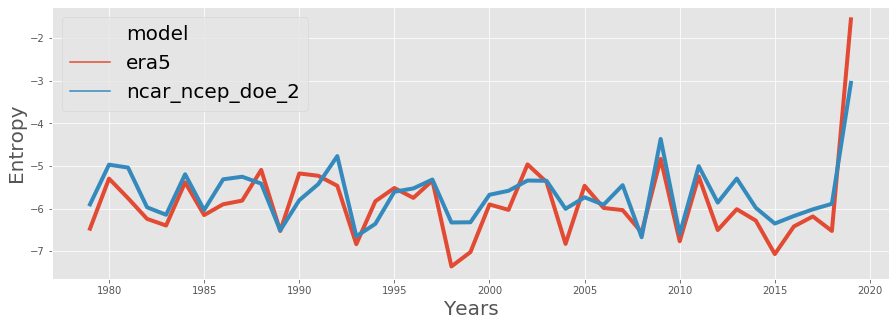

In [12]:
# plot the entropy
fig, ax = plt.subplots( figsize=(15, 5))

sns.lineplot(ax=ax, x='year', y='h', hue='model', data=results_df, linewidth=4,)
# sns.lineplot(ax=ax, x='nm_features', y='I', data=ndvi_df, label=label_main, linewidth=4,)
ax.set_xlabel('Years', fontsize=20)
ax.set_ylabel('Entropy', fontsize=20)
# ax.set_ylim([34, 38])
plt.legend(fontsize=20)
plt.show()
fig.savefig(f"{fig_path}mlsp_h.png")

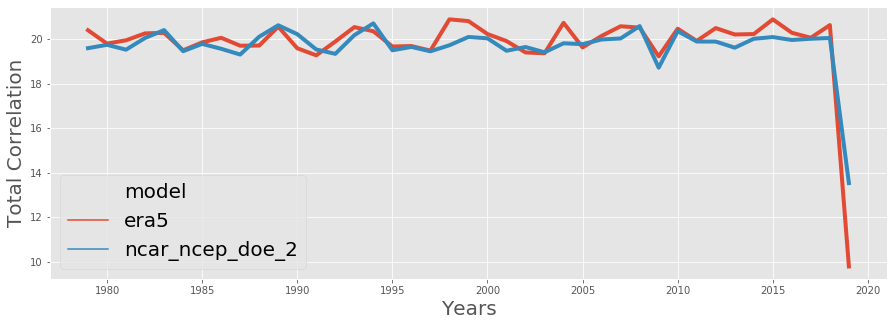

In [13]:
# plot the entropy
fig, ax = plt.subplots( figsize=(15, 5))

sns.lineplot(ax=ax, x='year', y='tc', hue='model', data=results_df, linewidth=4,)
# sns.lineplot(ax=ax, x='nm_features', y='I', data=ndvi_df, label=label_main, linewidth=4,)
ax.set_xlabel('Years', fontsize=20)
ax.set_ylabel('Total Correlation', fontsize=20)
plt.legend(fontsize=20)
plt.show()
fig.savefig(f"{fig_path}mlsp_tc.png")

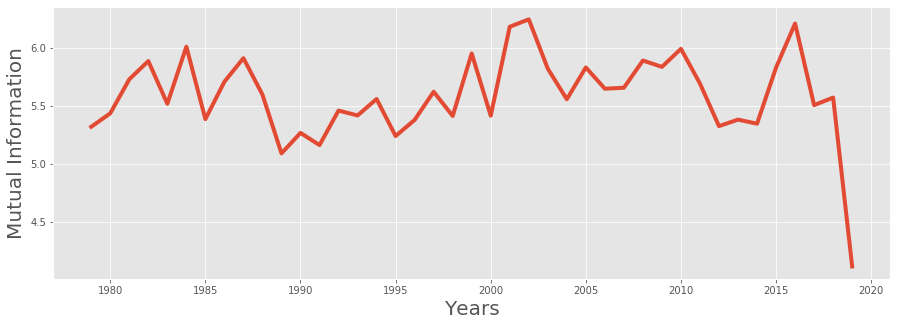

In [14]:
# plot the mutual information
fig, ax = plt.subplots( figsize=(15, 5))

sns.lineplot(ax=ax, x='year', y='mi', data=results_df, linewidth=4,)
# sns.lineplot(ax=ax, x='nm_features', y='I', data=ndvi_df, label=label_main, linewidth=4,)
ax.set_xlabel('Years', fontsize=20)
ax.set_ylabel('Mutual Information', fontsize=20)
# plt.legend(fontsize=20)
plt.show()
fig.savefig(f"{fig_path}mlsp_mi.png")